In [1]:
import typing as t
import numpy as np
import itertools

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.metrics import accuracy_score

from scipy.spatial import distance

import matplotlib.pyplot as plt

import random


In [2]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_wine

data_iris = load_iris()
Y_iris = data_iris.target
X_iris = data_iris.data

data_wine = load_wine()
Y_wine = data_wine.target
X_wine = data_wine.data
X_wine = X_wine[:,0:4]

In [3]:
from sklearn.model_selection import train_test_split
X_train_iris, X_test_iris, Y_train_iris, Y_test_iris = train_test_split(X_iris, Y_iris, test_size = 0.1)
X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(X_wine, Y_wine, test_size = 0.1)

In [4]:
from sklearn.svm import SVC
model_iris = SVC(kernel = 'linear')
model_iris.fit(X_train_iris, Y_train_iris)
print("iris dataset train accuracy: " + str(model_iris.score(X_train_iris, Y_train_iris)))
print("iris dataset test accuracy: " + str(model_iris.score(X_test_iris, Y_test_iris)))
print("-----------------------------------------------")
model_wine = SVC(kernel = 'linear')
model_wine.fit(X_train_wine, Y_train_wine)
print("wine dataset train accuracy: " + str(model_wine.score(X_train_wine, Y_train_wine)))
print("wine dataset train accuracy: " + str(model_wine.score(X_test_wine, Y_test_wine)))

iris dataset train accuracy: 0.9925925925925926
iris dataset test accuracy: 1.0
-----------------------------------------------
wine dataset train accuracy: 0.85625
wine dataset train accuracy: 0.7777777777777778


In [5]:
def precompute_fx(X: np.ndarray, Y: np.ndarray) -> t.Dict[str, t.Any]:

    prepcomp_vals = {}
    
    classes, class_freqs = np.unique(Y, return_counts=True)
    cls_index = [np.equal(Y, i) for i in range(classes.shape[0])]

    #cls_n_ex = np.array([np.sum(aux) for aux in cls_index])
    cls_n_ex = list(class_freqs)
    ovo_comb = list(itertools.combinations(range(classes.shape[0]), 2))
    prepcomp_vals["ovo_comb"] = ovo_comb
    prepcomp_vals["cls_index"] = cls_index
    prepcomp_vals["cls_n_ex"] = cls_n_ex
    return prepcomp_vals

In [6]:
# iris dataset precompute
precomp_fx_iris = precompute_fx(X_iris, Y_iris)
cls_index_iris = precomp_fx_iris['cls_index'] #true-false
cls_n_ex_iris = precomp_fx_iris['cls_n_ex']   # number of elements in each class
ovo_comb_iris = precomp_fx_iris['ovo_comb']   # pairs

# iris dataset precompute
precomp_fx_wine = precompute_fx(X_wine, Y_wine)
cls_index_wine = precomp_fx_wine['cls_index'] #true-false
cls_n_ex_wine = precomp_fx_wine['cls_n_ex']   # number of elements in each class
ovo_comb_wine = precomp_fx_wine['ovo_comb']   # pairs

In [7]:
# iris
prepcomp_vals_iris = {}
classes, class_freqs = np.unique(Y_iris, return_counts=True)
cls_index = [np.equal(Y_iris, i) for i in range(classes.shape[0])]
#cls_n_ex = np.array([np.sum(aux) for aux in cls_index])
cls_n_ex_iris = list(class_freqs)
ovo_comb_iris = list(itertools.combinations(range(classes.shape[0]), 2))
prepcomp_vals_iris["ovo_comb"] = ovo_comb_iris
prepcomp_vals_iris["cls_index"] = cls_index_iris
prepcomp_vals_iris["cls_n_ex"] = cls_n_ex_iris

# wine
prepcomp_vals_wine = {}
classes, class_freqs = np.unique(Y_wine, return_counts=True)
cls_index_wine = [np.equal(Y_wine, i) for i in range(classes.shape[0])]
#cls_n_ex = np.array([np.sum(aux) for aux in cls_index])
cls_n_ex_wine = list(class_freqs)
ovo_comb_wine = list(itertools.combinations(range(classes.shape[0]), 2))
prepcomp_vals_wine["ovo_comb"] = ovo_comb_wine
prepcomp_vals_wine["cls_index"] = cls_index_wine
prepcomp_vals_wine["cls_n_ex"] = cls_n_ex_wine

In [11]:
X_wine[cls_index_wine[0]].shape

(59, 4)

## Feature-based Measures

### 1- Maximum Fisher’s Discriminant Ratio (F1)

In [12]:
def numerator (X: np.ndarray, cls_index, cls_n_ex, i) -> float:
    return np.sum([cls_n_ex[j]*np.power((np.mean(X[cls_index[j], i])-np.mean(X[:, i], axis=0)),2) for j in range (len(cls_index))])
# according to aquation(3)

In [13]:
def denominator (X: np.ndarray, cls_index, cls_n_ex, i) -> float:
    return np.sum([np.sum(np.power(X[cls_index[j], i]-np.mean(X[cls_index[j], i], axis=0), 2)) for j in range(0, len(cls_n_ex))])
# according to aquation(3)

In [14]:
def compute_rfi (X: np.ndarray, cls_index, cls_n_ex) -> float:
    return [numerator (X, cls_index, cls_n_ex, i)/denominator(X, cls_index, cls_n_ex, i) for i in range(np.shape(X)[1])]

In [15]:
def ft_F1(X: np.ndarray, cls_index: np.ndarray, cls_n_ex: np.ndarray) -> float:
    return 1/(1 + np.max(compute_rfi (X, cls_index, cls_n_ex)))

In [16]:
print("iris dataset F1 score: ", str(ft_F1(X_iris, cls_index_iris, cls_n_ex_iris)))
print("wine dataset F1 score: ", str(ft_F1(X_wine, cls_index_wine, cls_n_ex_wine)))

iris dataset F1 score:  0.05862828094263205
wine dataset F1 score:  0.39312127756629367


### The Directional-vector MaximumFisher's Discreminant Ratio (F1v)

In [17]:
def dVector(X: np.ndarray, y_class1: np.ndarray, y_class2: np.ndarray) -> float:
    X_class1 = X[y_class1]; u_class1 = np.mean(X_class1, axis= 0)
    X_class2 = X[y_class2]; u_class2 = np.mean(X_class2, axis= 0)
    
    W = ((np.shape(X_class1)[0]/ (np.shape(X_class1)[0] + np.shape(X_class2)[0]))* np.cov(X_class1.T)) \
     + (np.shape(X_class2)[0]/(np.shape(X_class1)[0] + (np.shape(X_class2)[0])) * np.cov(X_class2.T))
    
    d = np.dot(np.linalg.inv(W), (u_class1 - u_class2))
    
    B = np.dot((u_class1 - u_class2),((u_class1 - u_class2).T))
    
    return np.dot(np.dot(d.T, B), d)/ np.dot(np.dot(d.T, W), d)

In [18]:
def ft_F1v(X: np.ndarray, ovo_comb: np.ndarray, cls_index: np.ndarray) ->float:
    df_list = []
    
    for idx1, idx2 in ovo_comb:
        y_class1 = cls_index[idx1]
        y_class2 = cls_index[idx2]
        dF = dVector(X, y_class1, y_class2)
        df_list.append(1/(1+dF))
        
    return np.mean(df_list)

In [19]:
print("iris dataset F1v score: ", str(ft_F1v(X_iris, ovo_comb_iris, cls_index_iris)))
print("wine dataset F1v score: ", str(ft_F1v(X_wine, ovo_comb_wine, cls_index_wine)))

iris dataset F1v score:  0.01000700313983178
wine dataset F1v score:  0.0156401809108022


### 2- Volume of Overlapping Region (F2)¶

In [20]:
def _minmax(X: np.ndarray, class1: np.ndarray, class2: np.ndarray) -> np.ndarray:
    """ This function computes the minimum of the maximum values per class
    for all features.
    """
    max_cls = np.zeros((2, X.shape[1]))
    max_cls[0, :] = np.max(X[class1], axis=0)
    max_cls[1, :] = np.max(X[class2], axis=0)
    aux = np.min(max_cls, axis=0)
    
    return aux

In [21]:
def _minmin(X: np.ndarray, class1: np.ndarray, class2: np.ndarray) -> np.ndarray:
    """ This function computes the minimum of the minimum values per class
    for all features.
    """
    min_cls = np.zeros((2, X.shape[1]))
    min_cls[0, :] = np.min(X[class1], axis=0)
    min_cls[1, :] = np.min(X[class2], axis=0)
    aux = np.min(min_cls, axis=0)
    
    return aux

In [22]:
def _maxmin(X: np.ndarray, class1: np.ndarray, class2: np.ndarray) -> np.ndarray:
    """ This function computes the maximum of the minimum values per class
    for all features.
    """
    min_cls = np.zeros((2, X.shape[1]))
    min_cls[0, :] = np.min(X[class1], axis=0)
    min_cls[1, :] = np.min(X[class2], axis=0)
    aux = np.max(min_cls, axis=0)
    
    return aux

In [23]:
def _maxmax(X: np.ndarray, class1: np.ndarray, class2: np.ndarray) -> np.ndarray:
    """ This function computes the maximum of the maximum values per class
    for all features. 
    """
    max_cls = np.zeros((2, X.shape[1]))
    max_cls[0, :] = np.max(X[class1], axis=0)
    max_cls[1, :] = np.max(X[class2], axis=0)
    aux = np.max(max_cls, axis=0)
    return aux

In [24]:
def ft_F2(X: np.ndarray, ovo_comb: np.ndarray, cls_index: np.ndarray) -> float:
    f2_list = []
    
    for idx1, idx2 in ovo_comb:
        y_class1 = cls_index[idx1]
        y_class2 = cls_index[idx2]
        zero_ = np.zeros(np.shape(X)[1])
        overlap_ = np.maximum(zero_, _minmax(X, y_class1, y_class2)-_maxmin(X, y_class1, y_class2))
        range_ = _maxmax(X, y_class1, y_class2)-_minmin(X, y_class1, y_class2)
        ratio = overlap_/range_
        f2_list.append(np.prod(ratio))
        
    return np.mean(f2_list)

In [25]:
print("iris dataset F2 score: ", str(ft_F2(X_iris, ovo_comb_iris, cls_index_iris)))
print("wine dataset F2 score: ", str(ft_F2(X_wine, ovo_comb_wine, cls_index_wine)))

iris dataset F2 score:  0.0063817663817663794
wine dataset F2 score:  0.0853552067458055


### 3- Maximum Individual Feature Efficiency (F3)

In [26]:
def _compute_f3(X_: np.ndarray, minmax_: np.ndarray, maxmin_: np.ndarray) -> np.ndarray:
    """ This function computes the F3 complexity measure given minmax and maxmin."""

    overlapped_region_by_feature = np.logical_and(X_ >= maxmin_, X_ <= minmax_)

    n_fi = np.sum(overlapped_region_by_feature, axis=0)
    idx_min = np.argmin(n_fi)

    return idx_min, n_fi, overlapped_region_by_feature

In [27]:
def ft_F3(X: np.ndarray, ovo_comb: np.ndarray, cls_index: np.ndarray, cls_n_ex: np.ndarray) -> np.ndarray:
    
    f3 = []
    for idx1, idx2 in ovo_comb:
        idx_min, n_fi, _ = _compute_f3(X, _minmax(X, cls_index[idx1], cls_index[idx2]),
        _maxmin(X, cls_index[idx1], cls_index[idx2]))
    f3.append(n_fi[idx_min] / (cls_n_ex[idx1] + cls_n_ex[idx2]))

    return np.mean(f3)

In [28]:
print("iris dataset F3 score: ", str(ft_F3(X_iris, ovo_comb_iris, cls_index_iris, cls_n_ex_iris)))
print("wine dataset F3 score: ", str(ft_F3(X_wine, ovo_comb_wine, cls_index_wine, cls_n_ex_wine)))

iris dataset F3 score:  0.37
wine dataset F3 score:  1.0084033613445378


### Colective Feature Efficiency (F4)

In [29]:
def ft_F4(X: np.ndarray, ovo_comb, cls_index, cls_n_ex) -> np.ndarray:

    f4 = []
    for idx1, idx2 in ovo_comb:
        aux = 0

        y_class1 = cls_index[idx1]
        y_class2 = cls_index[idx2]
        sub_set = np.logical_or(y_class1, y_class2)
        y_class1 = y_class1[sub_set]
        y_class2 = y_class2[sub_set]
        X_ = X[sub_set, :]
        # X_ = X[np.logical_or(y_class1, y_class2),:]
    
        while X_.shape[1] > 0 and X_.shape[0] > 0:
            # True if the example is in the overlapping region
            idx_min, _, overlapped_region_by_feature = _compute_f3(X_,_minmax(X_, y_class1, y_class2),_maxmin(X_, y_class1, y_class2))

            # boolean that if True, this example is in the overlapping region
            overlapped_region = overlapped_region_by_feature[:, idx_min]

            # removing the non overlapped features
            X_ = X_[overlapped_region, :]
            y_class1 = y_class1[overlapped_region]
            y_class2 = y_class2[overlapped_region]

            if X_.shape[0] > 0:
                aux = X_.shape[0]
            else:
                aux = 0
            # removing the most efficient feature
            X_ = np.delete(X_, idx_min, axis=1)

        f4.append(aux/(cls_n_ex[idx1] + cls_n_ex[idx2]))
        
    return np.mean(f4)

In [30]:
print("iris dataset F4 score: ", str(ft_F4(X_iris, ovo_comb_iris, cls_index_iris, cls_n_ex_iris)))
print("wine dataset F4 score: ", str(ft_F4(X_wine, ovo_comb_wine, cls_index_wine, cls_n_ex_wine)))

iris dataset F4 score:  0.043333333333333335
wine dataset F4 score:  0.2864472891960523


# Measures of Linearity

### Sum of the Error Distance by Linear Programming (L1)

In [31]:
def ft_R1(model, X, Y):
    y = model.decision_function(X)
    w_norm = np.linalg.norm(model.coef_)
    dist = y / w_norm
    Y_predicted = model.predict(X)
    distance = 0
    for i in range(Y.shape[0]):
        if(Y_predicted[i] != Y[i]):
            distance += dist[i, 0] + dist[i, 1] + dist[i, 2]
    SumErrorDist = distance/(Y.shape[0]*3)
    L1 = SumErrorDist/(SumErrorDist + 1)
    return L1

In [32]:
print("iris dataset L1 score: ", str(ft_R1(model_iris, X_iris, Y_iris)))
print("wine dataset L1 score: ", str(ft_R1(model_wine, X_wine, Y_wine)))

iris dataset L1 score:  0.006232116277512949
wine dataset L1 score:  0.030350044622434947


### Error Rate of Linear Classifier (L2)

In [10]:
def ft_R2(model, X, Y):
    Y_predicted = model.predict(X)
    counter = 0
    for i in range(Y.shape[0]):
        if(Y_predicted[i] != Y[i]):
            counter += 1
    L2 = counter / Y.shape[0]
    return L2

In [11]:
print("iris dataset L2 score: ", str(ft_R2(model_iris, X_iris, Y_iris)))
print("wine dataset L2 score: ", str(ft_R2(model_wine, X_wine, Y_wine)))

iris dataset L2 score:  0.02
wine dataset L2 score:  0.1404494382022472


### Non-Linearity of a Linear Classifier (L3)

In [29]:
def ft_R3(model, X, cls_index, cls_n_ex):
    temp_x = []
    temp_y = []
    for i in range(len(cls_n_ex)):
        for j in range(cls_n_ex[i]):
            index = np.random.choice(cls_n_ex[i], 2, replace=False)
            points = X[cls_index[i]][index]
            rand = random.uniform(0, 1)
            temp_x.append(((points[1] - points[0])*rand) + points[0])
            temp_y.append(i)

    temp_x = np.asarray(temp_x)
    temp_y = np.asarray(temp_y)
    R3 = ft_R2(model, temp_x, temp_y) 
    return R3

In [31]:
print("wine dataset L3 score: ", str(ft_R3(model_iris, X_iris, cls_index_iris, cls_n_ex_iris)))
print("iris dataset L3 score: ", str(ft_R3(model_wine, X_wine, cls_index_wine, cls_n_ex_wine)))

wine dataset L3 score:  0.006666666666666667
iris dataset L3 score:  0.08426966292134831


# Neighborhood Measures

### Fraction of Borderline Points (N1)

In [10]:
def ft_N1(X: np.ndarray, y: np.ndarray, metric: str = "euclidean") -> np.ndarray:
    
    # 0-1 scaler
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
    X_ = scaler.transform(X)

    # compute the distance matrix and the minimum spanning tree.
    dist_m = np.triu(distance.cdist(X_, X_, metric), k=1)
    mst = minimum_spanning_tree(dist_m)
    
    plt.scatter(X[:, 0], X[:, 1])
    
    for edge in mst:
        i, j = edge
        plt.plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]], c='r')
    plt.show()
    
    node_i, node_j = np.where(mst.toarray() > 0)

    # which edges have nodes with different class
    which_have_diff_cls = y[node_i] != y[node_j]

    # number of different vertices connected
    aux = np.unique(np.concatenate([node_i[which_have_diff_cls],node_j[which_have_diff_cls]])).shape[0]

    return aux/X.shape[0]

###############################show mst

ValueError: not enough values to unpack (expected 2, got 1)

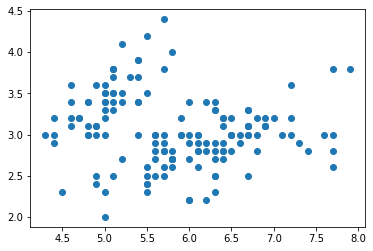

In [41]:
X = X_iris
y = Y_iris
metric = "euclidean"
scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_ = scaler.transform(X)

# compute the distance matrix and the minimum spanning tree.
dist_m = np.triu(distance.cdist(X_, X_, metric), k=1)
mst = minimum_spanning_tree(dist_m)

plt.scatter(X[:, 0], X[:, 1])

for edge in mst:
    i, j = edge
    plt.plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]], c='r')
plt.show()


ValueError: not enough values to unpack (expected 2, got 1)

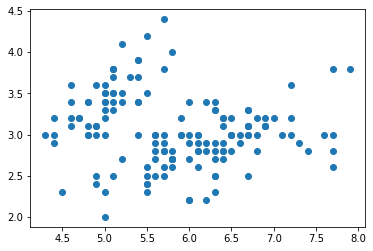

In [40]:
print("iris dataset N1 score: ", str(ft_N1(X_iris, Y_iris)))
# print("wine dataset N1 score: ", str(ft_N1(X_wine, Y_wine)))

In [72]:
mst.toarray().astype(float)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Ratio of Intra/Extra Class Nearest Neighbor Distance (N2)

In [17]:
def extra_nearest (X: np.ndarray, y: np.ndarray, cls_index: np.ndarray, 
                   i: int, metric: str = "euclidean", n_neighbors=1) :
    " This function computes the distance from a point x_i to their nearest enemy"
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
    X = scaler.transform(X)
    
    X_ = X[np.logical_not(cls_index[y[i]])]
    y_ = y[np.logical_not(cls_index[y[i]])]
    
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
    neigh.fit(X_, y_) 
    dist_enemy, pos_enemy = neigh.kneighbors([X[i, :]])
    dist_enemy = np.reshape(dist_enemy, (n_neighbors,))
    pos_enemy_ = np.reshape(pos_enemy, (n_neighbors,))
    query = X_[pos_enemy_, :]
    pos_enemy = np.where(np.all(X==query,axis=1))
    pos_enemy = np.reshape(pos_enemy, (n_neighbors,))
    return dist_enemy, pos_enemy

In [18]:
def intra_nearest (X: np.ndarray, y: np.ndarray, cls_index: np.ndarray,
                                  i: int, metric: str = "euclidean", n_neighbors=1) :
    " This function computes the distance from a point x_i to their nearest neighboor from its own class"
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
    X = scaler.transform(X)
    
    query = X[i, :]
    label_query = y[i]
    X_ = X[cls_index[label_query]]
    y_ = y[cls_index[label_query]]
    
    pos_query = np.where(np.all(X_==query,axis=1))
    X_ = np.delete(X_, pos_query, axis = 0)
    y_ = np.delete(y_, pos_query, axis = 0) 
    
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
    neigh.fit(X_, y_) 
    dist_neigh, pos_neigh = neigh.kneighbors([X[i, :]])
    dist_neigh = np.reshape(dist_neigh, (n_neighbors,))
    pos_neigh = np.reshape(pos_neigh, (n_neighbors,))
    return dist_neigh, pos_neigh

In [ ]:
def intra_extra(X: np.ndarray, y: np.ndarray, cls_index: np.ndarray):
    intra = np.sum([intra_nearest (X, y, cls_index, i)[0] for i in range(np.shape(X)[0])])
    extra = np.sum([extra_nearest (X, y, cls_index, i)[0] for i in range(np.shape(X)[0])])
    return intra/extra

In [ ]:
def ft_N2 (X: np.ndarray, y: np.ndarray, cls_index: np.ndarray):
    intra_extra_ = intra_extra(X, y, cls_index)
    return intra_extra_/(1+intra_extra_)

In [ ]:
print("iris dataset N2 score: ", str(ft_N2(X_iris, Y_iris, cls_index_iris)))
print("wine dataset N2 score: ", str(ft_N2(X_wine, Y_wine, cls_index_wine)))

### Error Rate of the Nearest Neighbor Classifier (N3)

In [ ]:
def ft_N3 (X: np.ndarray, y: np.ndarray, metric: str = "euclidean") -> float:
    
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
    X_ = scaler.transform(X)
    loo = LeaveOneOut()
    loo.get_n_splits(X_, y)
    
    y_test_ = []
    pred_y_ = []
    for train_index, test_index in loo.split(X_):
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = KNeighborsClassifier(n_neighbors=1, metric=metric)
        model.fit(X_train, y_train)
        pred_y = model.predict(X_test)
        y_test_.append(y_test)
        pred_y_.append(pred_y)
    
    error = 1 - accuracy_score(y_test_, pred_y_)
    return error

In [ ]:
print("iris dataset N3 score: ", str(ft_N3(X_iris, Y_iris)))
print("wine dataset N3 score: ", str(ft_N3(X_wine, Y_wine)))

### Non-Linearity of the Nearest Neighbor Classifier (N4)

In [ ]:
def ft_N4(X: np.ndarray, y: np.ndarray, cls_index: np.ndarray, 
          metric: str = "euclidean", p=2, n_neighbors=1) -> np.ndarray:
    interp_X = []
    interp_y = []

    # 0-1 scaler
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
    X = scaler.transform(X)
    
    for idx in cls_index:
        #creates a new dataset by interpolating pairs of training examples of the same class.
        X_ = X[idx]

        #two examples from the same class are chosen randomly and
        #they are linearly interpolated (with random coefficients), producing a new example.
        A = np.random.choice(X_.shape[0], X_.shape[0])
        A = X_[A]
        B = np.random.choice(X_.shape[0], X_.shape[0])
        B = X_[B]
        delta = np.random.ranf(X_.shape)
        interp_X_ = A + ((B - A) * delta)
        interp_y_ = y[idx]

        interp_X.append(interp_X_)
        interp_y.append(interp_y_)
    
    # join the datasets
    X_test = np.concatenate(interp_X)
    y_test = np.concatenate(interp_y)

    knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=p, metric=metric).fit(X, y)
    y_pred = knn.predict(X_test)
    error = 1 - accuracy_score(y_test, y_pred)

    return error

In [ ]:
print("iris dataset N4 score: ", str(ft_N4(X_iris, Y_iris, cls_index_iris)))
print("wine dataset N4 score: ", str(ft_N4(X_wine, Y_wine, cls_index_wine)))

### Fraction of Hyperspheres Covering Data (T1)

In [8]:
def distance_matrix (X: np.ndarray):
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
    X = scaler.transform(X)

    dist = distance.cdist(X, X, 'euclidean')
    return dist

In [34]:
D = distance_matrix(X_wine)

In [35]:
def radios (D: np.ndarray, y: np.ndarray, X: np.ndarray, 
                        cls_index:np.ndarray, i: int) -> float:
    d_i, x_j = extra_nearest(X, y, cls_index, i)
    d_j, x_k = extra_nearest(X, y, cls_index, x_j[0])
    if (i == x_k[0]):
        return d_i/2
    else :
        d_t = radios (D, y, X, cls_index, x_j[0]) 
        var = d_i - d_t
        return d_i - d_t

In [36]:
def hyperspher (D: np.ndarray, y: np.ndarray, X: np.ndarray, cls_index:np.ndarray) :

  aux = [radios(D, y, X, cls_index, i) for i in range(X.shape[0])]
  return aux

In [39]:
hyper_list = hyperspher(D, Y_iris, X_iris, cls_index_iris)

In [40]:
hyper_list

[array([0.36167364]),
 array([0.24950034]),
 array([0.3055788]),
 array([0.27472733]),
 array([0.39088173]),
 array([0.37838014]),
 array([0.32595467]),
 array([0.32773212]),
 array([0.26859901]),
 array([0.29016676]),
 array([0.33843654]),
 array([0.32589656]),
 array([0.28439124]),
 array([0.35003661]),
 array([0.49677778]),
 array([0.54112226]),
 array([0.41456086]),
 array([0.33750709]),
 array([0.37659395]),
 array([0.40790388]),
 array([0.240493]),
 array([0.36015883]),
 array([0.43529861]),
 array([0.21029417]),
 array([0.30724617]),
 array([0.22997973]),
 array([0.27071808]),
 array([0.35510809]),
 array([0.33524687]),
 array([0.28149169]),
 array([0.25507065]),
 array([0.21639515]),
 array([0.52890881]),
 array([0.53156324]),
 array([0.25938586]),
 array([0.30423638]),
 array([0.30041325]),
 array([0.41741605]),
 array([0.29109522]),
 array([0.3270765]),
 array([0.3460104]),
 array([0.20447397]),
 array([0.32761917]),
 array([0.26249241]),
 array([0.34883718]),
 array([0.22372

### Local Set Average Cardinality (LSC)

In [30]:
def LS_i (X: np.ndarray, y: np.ndarray, i: int, cls_index, metric: str = "euclidean"):
    dist_enemy, pos_enemy = extra_nearest(X, y, cls_index, i)
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
    X = scaler.transform(X)
    dist_ = distance.cdist(X, [X[i, :]], metric=metric)
    X_j = dist_[np.logical_and(dist_ < dist_enemy, dist_ != 0)]
    return X_j

In [31]:
def LSC (X, y, cls_index):
    n = np.shape(X)[0]
    x = [np.shape(LS_i(X, y, i, cls_index)) for i in range(n)]
    return 1 - np.sum(x)/n**2

In [32]:
print("iris dataset LSC score: ", str(LSC(X_iris, Y_iris, cls_index_iris)))
print("wine dataset LSC score: ", str(LSC(X_wine, Y_wine, cls_index_wine)))

iris dataset LSC score:  0.8243555555555555
wine dataset LSC score:  0.9491225855321298


## Network measures

In [75]:
X = X_iris
Y = Y_iris

In [76]:
D = distance_matrix(X)

In [77]:
F = D/D.max()

In [68]:
connected = np.zeros((F.shape))
for i in range(F.shape[0]):
    for j in range(F.shape[1]):
        if F[i, j] <= 0.15:
            connected[i, j] = 1
        if i == j:
            connected[i, j] = 0

In [79]:
for i in range(F.shape[0]):
    for j in range(F.shape[1]):
        if Y[i] != Y[j]:
            connected[i, j] = 0

In [80]:
E = connected.sum()

In [82]:
E = (E/2) ########

In [83]:
1 - (2*E)/(F.shape[0]*(F.shape[0]-1))

0.8487695749440716

In [95]:
def precompute_pca_tx(X: np.ndarray) -> t.Dict[str, t.Any]:
    prepcomp_vals = {}

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    pca = PCA(n_components=0.95)
    pca.fit(X)

    m_ = pca.explained_variance_ratio_.shape[0]
    m = X.shape[1]
    n = X.shape[0]

    prepcomp_vals["m_"] = m_
    prepcomp_vals["m"] = m
    prepcomp_vals["n"] = n

    return prepcomp_vals

In [96]:
def ft_T2(m: int, n: int) -> float:
    return m/n

In [97]:
def ft_T3(m_: int, n: int) -> float:
    return m_/n

In [98]:
def ft_T4(m: int, m_: int) -> float:
    return m_/m

In [99]:
precomp_pca = precompute_pca_tx(X)
m = precomp_pca['m']
n = precomp_pca['n']
m_ = precomp_pca['m_']

In [100]:
ft_T2(m, n)

0.02666666666666667

In [101]:
ft_T3(m_, n)

0.013333333333333334

In [104]:
ft_T4(m, m_)

0.5